Iter 0: Train Loss=2.3841, Test Loss=3.8933, Train Acc=0.2600, Test Acc=0.1200
Iter 250: Train Loss=0.0658, Test Loss=0.1416, Train Acc=0.9800, Test Acc=0.9400
Iter 500: Train Loss=0.0274, Test Loss=0.0829, Train Acc=1.0000, Test Acc=0.9800
Iter 750: Train Loss=0.0140, Test Loss=0.0126, Train Acc=1.0000, Test Acc=1.0000
Iter 1000: Train Loss=0.0960, Test Loss=0.0156, Train Acc=0.9600, Test Acc=1.0000
Iter 1250: Train Loss=0.0097, Test Loss=0.0114, Train Acc=1.0000, Test Acc=1.0000
Iter 1500: Train Loss=0.0145, Test Loss=0.0192, Train Acc=1.0000, Test Acc=1.0000
Iter 1750: Train Loss=0.0221, Test Loss=0.0528, Train Acc=1.0000, Test Acc=0.9800
Iter 2000: Train Loss=0.0267, Test Loss=0.0192, Train Acc=0.9800, Test Acc=1.0000
Iter 2250: Train Loss=0.0058, Test Loss=0.0064, Train Acc=1.0000, Test Acc=1.0000


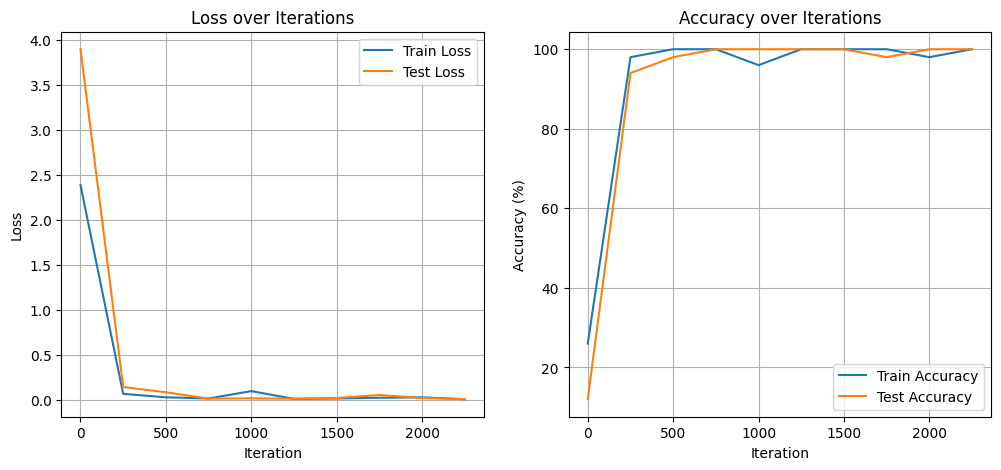


Final Train Accuracy: 99.11%
Final Test Accuracy: 98.82%


In [9]:
#1: 기본 CNN 모델 (TensorFlow 1.x 스타일)
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

tf.disable_v2_behavior()

# MNIST 데이터 로드 및 전처리
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0
train_x = train_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

# 네트워크 구조 설정
input_h, input_w, input_ch = 28, 28, 1
k1_ch, k2_ch = 32, 64
conv_result_size = 7 * 7 * k2_ch
n_hidden = 256
n_output = 10

# 플레이스홀더 정의
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

# 가중치 및 바이어스 초기화
weights = {
    'conv1': tf.Variable(tf.random.normal([5, 5, input_ch, k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([5, 5, k1_ch, k2_ch], stddev=0.1)),
    'fc': tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.1))
}
biases = {
    'conv1': tf.Variable(tf.random.normal([k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_ch], stddev=0.1)),
    'fc': tf.Variable(tf.random.normal([n_hidden], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_output], stddev=0.1))
}

# 신경망 모델 정의
def net(x):
    conv1 = tf.nn.relu(tf.nn.conv2d(x, weights['conv1'], strides=[1,1,1,1], padding='SAME') + biases['conv1'])
    pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, weights['conv2'], strides=[1,1,1,1], padding='SAME') + biases['conv2'])
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    flat = tf.reshape(pool2, [-1, conv_result_size])
    fc = tf.nn.relu(tf.matmul(flat, weights['fc']) + biases['fc'])
    out = tf.matmul(fc, weights['out']) + biases['out']
    return out

# 손실 함수 및 옵티마이저 정의
pred = net(x)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# 정확도 계산
correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(correct, tf.float32))

# 학습 설정
n_iter = 2500
n_batch = 50
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_train_record = []
loss_test_record = []
accr_train_record = []
accr_test_record = []

# 학습 반복
for epoch in range(n_iter):
    idx = np.random.choice(train_x.shape[0], n_batch, replace=False)
    batch_x, batch_y = train_x[idx], train_y[idx]
    sess.run(optm, feed_dict={x: batch_x, y: batch_y})

    if epoch % n_prt == 0:
        tidx = np.random.choice(test_x.shape[0], n_batch, replace=False)
        test_bx, test_by = test_x[tidx], test_y[tidx]

        train_loss, train_accr = sess.run([loss, accr], feed_dict={x: batch_x, y: batch_y})
        test_loss, test_accr = sess.run([loss, accr], feed_dict={x: test_bx, y: test_by})

        loss_train_record.append(train_loss)
        loss_test_record.append(test_loss)
        accr_train_record.append(train_accr)
        accr_test_record.append(test_accr)

        print(f"Iter {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Train Acc={train_accr:.4f}, Test Acc={test_accr:.4f}")

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(np.arange(len(loss_train_record))*n_prt, loss_train_record, label="Train Loss")
plt.plot(np.arange(len(loss_test_record))*n_prt, loss_test_record, label="Test Loss")
plt.title("Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(accr_train_record))*n_prt, np.array(accr_train_record)*100, label="Train Accuracy")
plt.plot(np.arange(len(accr_test_record))*n_prt, np.array(accr_test_record)*100, label="Test Accuracy")
plt.title("Accuracy over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# 전체 데이터셋에 대한 최종 정확도 출력
final_train_accuracy = sess.run(accr, feed_dict={x: train_x, y: train_y})
final_test_accuracy = sess.run(accr, feed_dict={x: test_x, y: test_y})

print(f"\nFinal Train Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

sess.close()

Iter 0: Train Loss=2.2577, Test Loss=2.5710, Train Acc=0.1600, Test Acc=0.0200
Iter 250: Train Loss=0.0496, Test Loss=0.1389, Train Acc=1.0000, Test Acc=0.9200
Iter 500: Train Loss=0.0339, Test Loss=0.0816, Train Acc=1.0000, Test Acc=0.9800
Iter 750: Train Loss=0.1610, Test Loss=0.2509, Train Acc=0.9600, Test Acc=0.9000
Iter 1000: Train Loss=0.0116, Test Loss=0.0177, Train Acc=1.0000, Test Acc=1.0000
Iter 1250: Train Loss=0.0940, Test Loss=0.0425, Train Acc=0.9800, Test Acc=0.9800
Iter 1500: Train Loss=0.0367, Test Loss=0.1237, Train Acc=0.9800, Test Acc=0.9800
Iter 1750: Train Loss=0.0300, Test Loss=0.0032, Train Acc=0.9800, Test Acc=1.0000
Iter 2000: Train Loss=0.0718, Test Loss=0.0690, Train Acc=0.9600, Test Acc=0.9800
Iter 2250: Train Loss=0.0082, Test Loss=0.1457, Train Acc=1.0000, Test Acc=0.9600


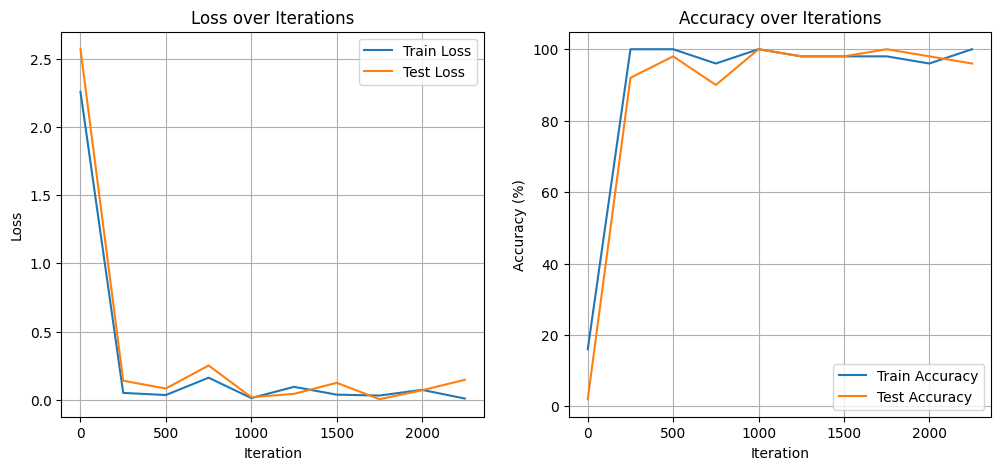


Final Train Accuracy: 99.12%
Final Test Accuracy: 98.89%


In [13]:
#2: Conv layer, FC layer 추가한 고급 CNN 모델
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

tf.disable_v2_behavior()

# MNIST 데이터 로드 및 전처리
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0
train_x = train_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

# 네트워크 구조 설정
input_h, input_w, input_ch = 28, 28, 1
k1_ch, k2_ch, k3_ch = 32, 64, 128
conv_result_size = 4 * 4 * k3_ch  # 마지막 conv 결과 크기 수정

n_hidden1 = 100
n_hidden2 = 64
n_output = 10

# 플레이스홀더 정의
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

# 가중치 및 바이어스 초기화
weights = {
    'conv1': tf.Variable(tf.random.normal([3, 3, input_ch, k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([3, 3, k1_ch, k2_ch], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([3, 3, k2_ch, k3_ch], stddev=0.1)),
    'fc1': tf.Variable(tf.random.normal([conv_result_size, n_hidden1], stddev=0.1)),
    'fc2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_hidden2, n_output], stddev=0.1))
}
biases = {
    'conv1': tf.Variable(tf.random.normal([k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_ch], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([k3_ch], stddev=0.1)),
    'fc1': tf.Variable(tf.random.normal([n_hidden1], stddev=0.1)),
    'fc2': tf.Variable(tf.random.normal([n_hidden2], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_output], stddev=0.1))
}

# 신경망 모델 정의
def net(x):
    conv1 = tf.nn.relu(tf.nn.conv2d(x, weights['conv1'], strides=[1,1,1,1], padding='SAME') + biases['conv1'])
    pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, weights['conv2'], strides=[1,1,1,1], padding='SAME') + biases['conv2'])
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv3 = tf.nn.relu(tf.nn.conv2d(pool2, weights['conv3'], strides=[1,1,1,1], padding='SAME') + biases['conv3'])
    pool3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    flat = tf.reshape(pool3, [-1, conv_result_size])
    fc1 = tf.nn.relu(tf.matmul(flat, weights['fc1']) + biases['fc1'])
    fc2 = tf.nn.relu(tf.matmul(fc1, weights['fc2']) + biases['fc2'])
    out = tf.matmul(fc2, weights['out']) + biases['out']
    return out

# 손실 함수 및 옵티마이저 정의
pred = net(x)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# 정확도 계산
correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(correct, tf.float32))

# 학습 설정
n_iter = 2500
n_batch = 50
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_train_record = []
loss_test_record = []
accr_train_record = []
accr_test_record = []

# 학습 반복
for epoch in range(n_iter):
    idx = np.random.choice(train_x.shape[0], n_batch, replace=False)
    batch_x, batch_y = train_x[idx], train_y[idx]
    sess.run(optm, feed_dict={x: batch_x, y: batch_y})

    if epoch % n_prt == 0:
        tidx = np.random.choice(test_x.shape[0], n_batch, replace=False)
        test_bx, test_by = test_x[tidx], test_y[tidx]

        train_loss, train_accr = sess.run([loss, accr], feed_dict={x: batch_x, y: batch_y})
        test_loss, test_accr = sess.run([loss, accr], feed_dict={x: test_bx, y: test_by})

        loss_train_record.append(train_loss)
        loss_test_record.append(test_loss)
        accr_train_record.append(train_accr)
        accr_test_record.append(test_accr)

        print(f"Iter {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Train Acc={train_accr:.4f}, Test Acc={test_accr:.4f}")

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(np.arange(len(loss_train_record))*n_prt, loss_train_record, label="Train Loss")
plt.plot(np.arange(len(loss_test_record))*n_prt, loss_test_record, label="Test Loss")
plt.title("Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(accr_train_record))*n_prt, np.array(accr_train_record)*100, label="Train Accuracy")
plt.plot(np.arange(len(accr_test_record))*n_prt, np.array(accr_test_record)*100, label="Test Accuracy")
plt.title("Accuracy over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# 전체 데이터셋에 대한 최종 정확도 출력
final_train_accuracy = sess.run(accr, feed_dict={x: train_x, y: train_y})
final_test_accuracy = sess.run(accr, feed_dict={x: test_x, y: test_y})

print(f"\nFinal Train Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

sess.close()